## Overview and Interpretation of GTEx Resources: eQTLs and Gene Expression


This notebook illustrates how to parse the GTEx data tables and resources available from the [GTEx Portal](https://gtexportal.org), including:
* Sample and subject attributes
* Expression tables
* eQTL results

All examples use data from the V7 release.

#### Pre-requisites

**_For the online version of this notebook, all datasets used in the examples are available to the notebook, and no additional files are required._**

To run the notebook elsewhere, the following files are needed (all are available from the [downloads](https://gtexportal.org/home/datasets) section of the portal):
* GTEx_v7_Annotations_SampleAttributesDS.txt
* GTEx_v7_Annotations_SubjectPhenotypesDS.txt
* GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct.gz
* GTEx_Analysis_v7_eQTL.tar.gz

Uncompress GTEx_Analysis_v7_eQTL.tar.gz, and make sure that the contents of the resulting GTEx_Analysis_v7_eQTL directory are in the same location as the other files. In the code below, it is assumed that all data is stored in a `data` directory, at the same level as this notebook.

#### Python environment

We will use the `pandas` library to read and parse the data. Run the following import statements to set up the environment:

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

### Selecting samples and subsets of the data

To begin, we will explore the sample and subject annotations. Load the two tables:

In [2]:
sample_df = pd.read_csv('data/GTEx_v7_Annotations_SampleAttributesDS.txt', sep='\t', index_col=0)
subject_df = pd.read_csv('data/GTEx_v7_Annotations_SubjectPhenotypesDS.txt', sep='\t', index_col=0)

Explanations for each column header can be found in the dictionary spreadsheets available on the portal (provided here for convenience):<br>
[GTEx_Analysis_v7_Annotations_SubjectPhenotypesDD.xlsx](data/GTEx_Analysis_v7_Annotations_SubjectPhenotypesDD.xlsx)<br>
[GTEx_Analysis_v7_Annotations_SampleAttributesDD.xlsx](data/GTEx_Analysis_v7_Annotations_SampleAttributesDD.xlsx)

#### Subject attributes

To view the first few rows of the subject attributes, run:

In [3]:
subject_df.head()

,SEX,AGE,DTHHRDY
SUBJID,,,
GTEX-1117F,2,60-69,4.0
GTEX-111CU,1,50-59,0.0
GTEX-111FC,1,60-69,1.0
GTEX-111VG,1,60-69,3.0
GTEX-111YS,1,60-69,0.0


The `DTHHRDY` column encodes the death classification based on the 4-point _Hardy Scale_. The coding corresponds to the following categories:<br>
0: Ventilator Case; 1: Violent and fast death; 2: Fast death of natural causes; 3: Intermediate death; 4: Slow death

For additional details on the subject attributes, see [GTEx_Analysis_v7_Annotations_SubjectPhenotypesDD.xlsx](data/GTEx_Analysis_v7_Annotations_SubjectPhenotypesDD.xlsx).

_Note that the attribute tables from the GTEx Portal contain open-access data only; protected information (e.g., exact donor age, phenotypic information, etc.) is available from dbGaP._ Consequently, only age ranges are provided here.

#### Sample attributes

The sample attributes file contains information on all samples in the GTEx resource, including RNA-seq samples and whole genome sequence (WGS) samples.

In [4]:
sample_df.head()

,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,SMUBRID,SMTSISCH,SMTSPAX,SMNABTCH,...,SME1ANTI,SMSPLTRD,SMBSMMRT,SME1SNSE,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS
SAMPID,,,,,,,,,,,,,,,,,,,,,
GTEX-1117F-0003-SM-58Q7G,NaN,B1,NaN,NaN,Blood,Whole Blood,0013756,1188.0,NaN,BP-38516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0003-SM-5DWSB,NaN,B1,NaN,NaN,Blood,Whole Blood,0013756,1188.0,NaN,BP-38516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0003-SM-6WBT7,NaN,B1,NaN,NaN,Blood,Whole Blood,0013756,1188.0,NaN,BP-38543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0226-SM-5GZZ7,0.0,B1,"2 pieces, ~15% vessel stroma, rep delineated",6.8,Adipose Tissue,Adipose - Subcutaneous,0002190,1214.0,1125.0,BP-43693,...,14579275.0,12025354.0,0.003164,14634407.0,50.094357,0.003102,0.992826,NaN,0.0,50.12628
GTEX-1117F-0426-SM-5EGHI,0.0,B1,"2 pieces, !5% fibrous connective tissue, delin...",7.1,Muscle,Muscle - Skeletal,0011907,1220.0,1119.0,BP-43495,...,13134349.0,11578874.0,0.003991,13307871.0,50.328114,0.006991,0.994212,NaN,0.0,49.90517


Each GTEx release defines an analysis freeze containing samples that pass all quality controls, for each sample type. The analysis freeze column is called `SMAFRZE`. For a summary of analysis freeze samples of each data type in the V7 release, run:

In [5]:
sample_df['SMAFRZE'].value_counts()

RNASEQ     11688
EXCLUDE     2232
WGS          635
WES          593
OMNI         450
Name: SMAFRZE, dtype: int64

Here, we'll focus on the RNA-seq samples. To facilitate this, we define a new data frame containing the RNA-seq analysis freeze samples only:

In [6]:
rnaseq_sample_df = sample_df[sample_df['SMAFRZE']=='RNASEQ']

To view the first few rows of attributes for these samples, run

In [7]:
rnaseq_sample_df.head()

,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,SMUBRID,SMTSISCH,SMTSPAX,SMNABTCH,...,SME1ANTI,SMSPLTRD,SMBSMMRT,SME1SNSE,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS
SAMPID,,,,,,,,,,,,,,,,,,,,,
GTEX-1117F-0226-SM-5GZZ7,0.0,B1,"2 pieces, ~15% vessel stroma, rep delineated",6.8,Adipose Tissue,Adipose - Subcutaneous,0002190,1214.0,1125.0,BP-43693,...,14579275.0,12025354.0,0.003164,14634407.0,50.094357,0.003102,0.992826,NaN,0.0,50.126280
GTEX-1117F-0426-SM-5EGHI,0.0,B1,"2 pieces, !5% fibrous connective tissue, delin...",7.1,Muscle,Muscle - Skeletal,0011907,1220.0,1119.0,BP-43495,...,13134349.0,11578874.0,0.003991,13307871.0,50.328114,0.006991,0.994212,NaN,0.0,49.905170
GTEX-1117F-0526-SM-5EGHJ,0.0,B1,"2 pieces, clean, Monckebeg medial sclerosis, r...",8.0,Blood Vessel,Artery - Tibial,0007610,1221.0,1120.0,BP-43495,...,13169835.0,11015113.0,0.004285,13160068.0,49.981450,0.002867,0.992711,NaN,0.0,50.227848
GTEX-1117F-0626-SM-5N9CS,1.0,B1,"2 pieces, up to 4mm aderent fat/nerve/vessel, ...",6.9,Blood Vessel,Artery - Coronary,0001621,1243.0,1098.0,BP-43956,...,15148343.0,11624467.0,0.003379,15282444.0,50.220333,0.005335,0.991175,NaN,0.0,50.025043
GTEX-1117F-0726-SM-5GIEN,1.0,B1,"2 pieces, no abnormalities",6.3,Heart,Heart - Atrial Appendage,0006631,1244.0,1097.0,BP-44261,...,13583226.0,9262806.0,0.003451,13745609.0,50.297090,0.030579,0.994478,NaN,0.0,49.929870


One of the key columns in the sample attribute table is `SMTSD`, which stands for 'Tissue Site Detail'. This enables the selection of samples from a specific tissue. For example, to obtain a summary of sample sizes in each tissue, run:

In [8]:
rnaseq_sample_df['SMTSD'].value_counts()

Muscle - Skeletal                            564
Skin - Sun Exposed (Lower leg)               473
Thyroid                                      446
Adipose - Subcutaneous                       442
Artery - Tibial                              441
Lung                                         427
Nerve - Tibial                               414
Esophagus - Mucosa                           407
Whole Blood                                  407
Skin - Not Sun Exposed (Suprapubic)          387
Esophagus - Muscularis                       370
Adipose - Visceral (Omentum)                 355
Cells - Transformed fibroblasts              343
Heart - Left Ventricle                       303
Artery - Aorta                               299
Heart - Atrial Appendage                     297
Breast - Mammary Tissue                      290
Colon - Transverse                           274
Stomach                                      262
Testis                                       259
Pancreas            

We can also visualize this as a bar chart:

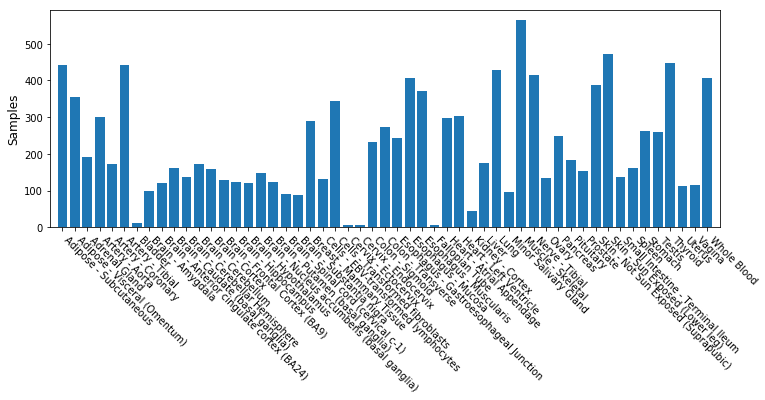

In [9]:
sample_size_df = rnaseq_sample_df['SMTSD'].value_counts().sort_index()

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
x = np.arange(len(sample_size_df))
ax.bar(x, sample_size_df.values, width=0.8)
plt.xticks(x, sample_size_df.index, rotation=-45, ha='left', fontsize=10)
ax.set_xlim([x[0]-1,x[-1]+1])
ax.set_ylabel('Samples', fontsize=12);

The RNA-seq samples corresponding to a given tissue can be selected using the `SMTSD` column:

In [10]:
pancreas_sample_df = rnaseq_sample_df[rnaseq_sample_df['SMTSD']=='Pancreas']
pancreas_sample_df.head()

,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,SMUBRID,SMTSISCH,SMTSPAX,SMNABTCH,...,SME1ANTI,SMSPLTRD,SMBSMMRT,SME1SNSE,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS
SAMPID,,,,,,,,,,,,,,,,,,,,,
GTEX-111CU-0526-SM-5EGHK,1.0,B1,"2 pieces, include 20 and 40% fat (attached and...",7.2,Pancreas,Pancreas,0001150,72.0,637.0,BP-43495,...,13106749.0,15136415.0,0.008059,13257128.0,50.285200,0.001842,0.992940,NaN,0.0,49.936325
GTEX-111YS-1226-SM-5EGGJ,1.0,B1,2 somewhat fragmented pieces,6.8,Pancreas,Pancreas,0001150,154.0,735.0,BP-44460,...,15480965.0,20021609.0,0.005362,15599862.0,50.191270,0.003316,0.993188,NaN,0.0,50.074604
GTEX-1122O-0726-SM-5GIEV,1.0,B1,"2 pieces, minimal attached and internal fat",6.0,Pancreas,Pancreas,0001150,55.0,948.0,BP-44261,...,21587613.0,25147179.0,0.006104,21545407.0,49.951077,0.002716,0.993875,NaN,0.0,50.221860
GTEX-1128S-0826-SM-5GZZI,1.0,B1,"2 pieces, up to 50% interstital fat, rep delin...",6.2,Pancreas,Pancreas,0001150,842.0,1003.0,BP-43753,...,18722483.0,20292290.0,0.005499,18640983.0,49.890940,0.004870,0.993642,NaN,0.0,50.145958
GTEX-117YX-0226-SM-5EGH6,1.0,B1,"2 pieces; well dissected, no fat",7.0,Pancreas,Pancreas,0001150,80.0,726.0,BP-44460,...,15319276.0,18135569.0,0.007021,15453346.0,50.217842,0.004132,0.992800,NaN,0.0,49.853798


All GTEx samples are indexed using the same identifier format. Importantly, the first two components of a *sample ID* correspond to the *donor ID* for that sample. For example, to obtain the donor IDs corresponding to the samples selected above:

In [11]:
pancreas_sample_df.index[:3].tolist()  # show the first 3 sample IDs

['GTEX-111CU-0526-SM-5EGHK',
 'GTEX-111YS-1226-SM-5EGGJ',
 'GTEX-1122O-0726-SM-5GIEV']

run the following:

In [12]:
donor_ids = pancreas_sample_df.index.map(lambda x: '-'.join(x.split('-')[:2]))
print(donor_ids[:3].tolist())  # show the first 3 donor IDs

['GTEX-111CU', 'GTEX-111YS', 'GTEX-1122O']


Samples can then be split by donor attribute as follows:

In [13]:
pancreas_male_df = pancreas_sample_df.loc[subject_df.loc[donor_ids, 'SEX'].values==1]  # males are encoded as 1
pancreas_female_df = pancreas_sample_df.loc[subject_df.loc[donor_ids, 'SEX'].values==2]  # females are encoded as 2

### Loading expression data
Next, after having selected a specific set of samples, we show how to load the expression data corresponding to these samples. Gene-level expression is provided as raw read counts and in TPM (transcripts per million); here we will use the TPM data. Both tables are in GCT format, which contains two rows of header data. The first two columns contain the gene ID and gene name; since gene names are not unique, **all GTEx tables are indexed by GENCODE/ENSEMBL gene ID**.

In [14]:
# to select a specific set of samples, pass the IDs to 'read_csv':
pancreas_sample_ids = ['Name']+pancreas_sample_df.index.tolist()  # add 'Name' to load ENSEMBLE ID of the gene

tpm_df = pd.read_csv('data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.Pancreas.gct.gz', sep='\t', skiprows=2,
                       usecols=pancreas_sample_ids, index_col=0)
print('Number of genes in table: {}'.format(tpm_df.shape[0]))

Number of genes in table: 56202


The table contains data for all genes in the reference annotation:

In [15]:
tpm_df.head()

,GTEX-111CU-0526-SM-5EGHK,GTEX-111YS-1226-SM-5EGGJ,GTEX-1122O-0726-SM-5GIEV,GTEX-1128S-0826-SM-5GZZI,GTEX-117YX-0226-SM-5EGH6,GTEX-11DXX-0926-SM-5H112,GTEX-11EQ9-1026-SM-5H134,GTEX-11GSP-0426-SM-5A5KX,GTEX-11I78-0626-SM-5A5LZ,GTEX-11LCK-0226-SM-5A5M6,...,GTEX-ZT9W-0926-SM-57WFS,GTEX-ZTPG-1026-SM-5DUWP,GTEX-ZV7C-0726-SM-59HKH,GTEX-ZVP2-0726-SM-59HKY,GTEX-ZVT2-2026-SM-5NQ8Q,GTEX-ZVZP-0626-SM-59HL5,GTEX-ZYFG-0826-SM-5BC5T,GTEX-ZYW4-2126-SM-59HJ9,GTEX-ZYY3-0826-SM-5E44R,GTEX-ZZPU-0726-SM-5N9C8
Name,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.4,0.0000,0.0546,0.04141,0.06778,0.03802,0.03170,0.01529,0.06213,0.03664,0.01931,...,0.01598,0.01906,0.06286,0.10340,0.04275,0.03054,0.07476,0.10820,0.09764,0.03772
ENSG00000227232.4,3.0770,3.0170,5.28200,7.54500,3.42600,4.56800,4.84700,1.78200,3.65500,4.05800,...,3.91200,9.07500,6.90700,6.47800,4.18200,6.32800,5.20600,5.59100,6.64400,7.34400
ENSG00000243485.2,0.1564,0.1213,0.00000,0.03764,0.04222,0.03521,0.03396,0.10350,0.08139,0.00000,...,0.03549,0.12700,0.03491,0.09188,0.18990,0.06783,0.16610,0.04808,0.04338,0.00000
ENSG00000237613.2,0.0000,0.0000,0.01932,0.00000,0.02660,0.00000,0.04279,0.00000,0.12820,0.02703,...,0.00000,0.02667,0.00000,0.05789,0.00000,0.06411,0.07847,0.00000,0.00000,0.02640
ENSG00000268020.2,0.0000,0.0000,0.00000,0.06105,0.00000,0.00000,0.05507,0.00000,0.00000,0.00000,...,0.00000,0.03434,0.02831,0.03726,0.00000,0.00000,0.00000,0.00000,0.03518,0.00000


The expression of a specific gene can then be queried as

In [16]:
g = tpm_df.loc['ENSG00000254647.2']

To facilitate queries by gene name (as long as this is unique), a gene name &rarr; ID mapping can be constructed as follows. In the GCT tables, _Name_ contains the GENCODE ID, and _Description_ the gene name.

In [17]:
id_map = pd.read_csv('data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.Pancreas.gct.gz', sep='\t', skiprows=2,
                       usecols=['Name', 'Description'], index_col=1, squeeze=True).to_dict()

In [18]:
id_map['INS']

'ENSG00000254647.2'

In [19]:
g = tpm_df.loc[id_map['INS']]
g.head()

GTEX-111CU-0526-SM-5EGHK    1432.0
GTEX-111YS-1226-SM-5EGGJ    1317.0
GTEX-1122O-0726-SM-5GIEV    1190.0
GTEX-1128S-0826-SM-5GZZI    3515.0
GTEX-117YX-0226-SM-5EGH6    2810.0
Name: ENSG00000254647.2, dtype: float64

Working with pandas DataFrames provides many useful functionalities (note that many of these steps can be run with minimal changes in R). For example, the median expression across a set of samples can be simply calculated as

In [20]:
median_expr = tpm_df.median(axis=1)
median_expr.head()

Name
ENSG00000223972.4    0.027255
ENSG00000227232.4    5.553000
ENSG00000243485.2    0.034055
ENSG00000237613.2    0.022915
ENSG00000268020.2    0.000000
dtype: float64

and the median expression for a specific gene can then be queried as

In [21]:
median_expr[id_map['INS']]

2338.0

### Overview of the cis-eQTL data
In this section, we provide an overview of the cis-eQTL data. This consists of the following set of files (available from the GTEx Portal), for each tissue:
* Gene/eGene summary statistics<br>(files ending in *.egenes.txt.gz)
* The list of all significant variant-gene associations found in a tissue<br>(files ending in *.signif_variant_gene_pairs.txt.gz)
* The association results for all variant-gene pairs tested in a tissue<br>(files ending in *.allpairs.txt.gz)

Additionally, all input files used for eQTL mapping are available from the Portal, including normalized expression and covariates (both described in the tutorial).

Here, we will focus on the eGene summary and significant pair tables.

Begin by loading the gene summary table:

In [22]:
gene_df = pd.read_csv('data/Pancreas.v7.egenes.txt.gz', sep='\t', index_col=0)

To view the different columns available in this table, inspect a specific row:

In [23]:
gene_df.loc[id_map['INS']]

gene_name                                  INS
gene_chr                                    11
gene_start                             2181009
gene_end                               2182571
strand                                       -
num_var                                   9167
beta_shape1                            1.04048
beta_shape2                            1457.85
true_df                                163.574
pval_true_df                       0.000846469
variant_id                  11_2310683_G_A_b37
tss_distance                            128112
chr                                         11
pos                                    2310683
ref                                          G
alt                                          A
num_alt_per_site                             1
rs_id_dbSNP147_GRCh37p13           rs117595442
minor_allele_samples                        11
minor_allele_count                          11
maf                                      0.025
ref_factor   

As this example shows, the table contains data for all genes, not just eGenes. To select eGenes at FDR ≤ 0.05, corresponding to the set used in GTEx Consortium analyses, run:

In [24]:
egenes_df = gene_df[gene_df['qval']<=0.05]
print('Number of eGenes: {}'.format(egenes_df.shape[0]))

Number of eGenes: 7146


As a toy example, we'll next show how to extract all significant variant-gene pairs corresponding to the eGene with the strongest association in Pancreas.

In [25]:
egenes_df[['variant_id', 'pval_nominal']].sort_values('pval_nominal').head()

,variant_id,pval_nominal
gene_id,,
ENSG00000197728.5,12_56435929_C_G_b37,3.243440e-97
ENSG00000013573.12,12_31225344_A_G_b37,1.065180e-93
ENSG00000166435.11,11_74659302_A_T_b37,4.150050e-84
ENSG00000174652.13,19_9517537_C_G_b37,1.265260e-82
ENSG00000204792.2,2_75185856_G_T_b37,5.738330e-80


Load the association results for all significant variant-gene pairs:

In [26]:
pairs_df = pd.read_csv('data/Pancreas.v7.signif_variant_gene_pairs.txt.gz', sep='\t')

Then, select the pairs corresponding to the top gene:

In [27]:
selected_pairs_df = pairs_df[pairs_df['gene_id']=='ENSG00000197728.5']

In [28]:
selected_pairs_df.head()

,variant_id,gene_id,tss_distance,ma_samples,ma_count,maf,pval_nominal,slope,slope_se,pval_nominal_threshold,min_pval_nominal,pval_beta
486740,12_56271219_T_A_b37,ENSG00000197728.5,-164418,42,42,0.095454,2.491330e-05,-0.687914,0.159012,0.000041,3.243440e-97,9.644380e-89
486741,12_56354272_G_C_b37,ENSG00000197728.5,-81365,115,140,0.331754,8.268610e-14,0.681209,0.084259,0.000041,3.243440e-97,9.644380e-89
486742,12_56364321_A_G_b37,ENSG00000197728.5,-71316,122,149,0.341743,1.424730e-17,0.721492,0.076173,0.000041,3.243440e-97,9.644380e-89
486743,12_56366160_G_C_b37,ENSG00000197728.5,-69477,48,54,0.123288,2.009430e-05,0.580996,0.132702,0.000041,3.243440e-97,9.644380e-89
486744,12_56367966_C_T_b37,ENSG00000197728.5,-67671,40,45,0.102740,1.170990e-05,-0.577004,0.128026,0.000041,3.243440e-97,9.644380e-89


In [29]:
print('Significant variant-gene pairs for gene {}: {}'.format('ENSG00000197728.5', selected_pairs_df.shape[0]))

Significant variant-gene pairs for gene ENSG00000197728.5: 155


### eQTL-GWAS correlation

Since eQTLs are widespread, a GWAS signal can co-occur with an eQTL by chance. Co-localization analyses estimate the probability that overlapping GWAS and eQTL signals share the same causal variant(s). In an initial analysis, we will calculate the correlation between the association p-values of co-occuring GWAS and eQTL signals in a given tissue. As a toy example, we chose an association with Body Mass Index (BMI), rs2008514 from the [ENGAGE GWAS meta-analysis of BMI](http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1005230), and will test it against the eGene _TUFM_.

To begin, we specify the gene ID of the eGene, the chromosome position of the GWAS variant, and a window around the GWAS variant.

Similar to gene IDs, the GTEx data relies on variant IDs to uniquely identify variants by position and alleles. To facilitate matching variant IDs to dbSNP IDs, and vice versa, a lookup table is provided on the GTEx Portal:<br>GTEx_Analysis_2016-01-15_v7_WholeGenomeSeq_635Ind_PASS_AB02_GQ20_HETX_MISS15_PLINKQC.lookup_table.txt.gz

In [30]:
gene_id = 'ENSG00000178952.4'  # TUFM
chrom = '16'
gwas_variant_pos = 28825605 # bp
interval = 250000  # +/- from variant pos, bp

Next, we load the eQTL results for all variant-gene pairs tested (file ending with *.allpairs.txt.gz) in _Esophagus - Muscularis_. To speed up loading times for this tutorial, a file with a +/-1Mb window around the GWAS variant is provided.

In [31]:
eqtl_assoc_df = pd.read_csv('data/Esophagus_Muscularis_16_27889486_29889486.allpairs.txt.gz', sep='\t')
eqtl_assoc_df.head()

,gene_id,variant_id,tss_distance,ma_samples,ma_count,maf,pval_nominal,slope,slope_se
0,ENSG00000261557.1,16_27889649_G_C_b37,743149,75,78,0.116766,0.893321,-0.013399,0.099824
1,ENSG00000261557.1,16_27889677_G_A_b37,743177,159,183,0.273134,0.342530,-0.069369,0.072960
2,ENSG00000261557.1,16_27889733_A_T_b37,743233,48,50,0.074627,0.015645,-0.302678,0.124467
3,ENSG00000261557.1,16_27889755_T_A_b37,743255,28,28,0.041791,0.396627,-0.141046,0.166141
4,ENSG00000261557.1,16_27889861_A_G_b37,743361,186,220,0.329341,0.277242,-0.076273,0.070063


To facilitate parsing and comparison between eQTL and GWAS tables, we'll index the DataFrame by chromosome and variant position:

In [32]:
eqtl_assoc_df['variant_pos'] = eqtl_assoc_df['variant_id'].apply(lambda x: x.split('_')[1]).astype(int)
eqtl_assoc_df['chr'] = eqtl_assoc_df['variant_id'].apply(lambda x: x.split('_')[0])
eqtl_assoc_df.index = eqtl_assoc_df['chr']+'_'+eqtl_assoc_df['variant_pos'].astype(str)
eqtl_assoc_df.head()

,gene_id,variant_id,tss_distance,ma_samples,ma_count,maf,pval_nominal,slope,slope_se,variant_pos,chr
16_27889649,ENSG00000261557.1,16_27889649_G_C_b37,743149,75,78,0.116766,0.893321,-0.013399,0.099824,27889649,16
16_27889677,ENSG00000261557.1,16_27889677_G_A_b37,743177,159,183,0.273134,0.342530,-0.069369,0.072960,27889677,16
16_27889733,ENSG00000261557.1,16_27889733_A_T_b37,743233,48,50,0.074627,0.015645,-0.302678,0.124467,27889733,16
16_27889755,ENSG00000261557.1,16_27889755_T_A_b37,743255,28,28,0.041791,0.396627,-0.141046,0.166141,27889755,16
16_27889861,ENSG00000261557.1,16_27889861_A_G_b37,743361,186,220,0.329341,0.277242,-0.076273,0.070063,27889861,16


From this table, we'll select the subset containing the variants tested against the gene _TUFM_ in the +/- 250kb window around the GWAS variant:

In [33]:
eqtl_subset_df = eqtl_assoc_df.loc[
    (eqtl_assoc_df['gene_id']==gene_id) &
    (eqtl_assoc_df['variant_pos']>=gwas_variant_pos-interval) &
    (eqtl_assoc_df['variant_pos']<=gwas_variant_pos+interval)
]
print('Variants in GWAS interval: {}'.format(eqtl_subset_df.shape[0]))
eqtl_subset_df.index = eqtl_subset_df['chr']+'_'+eqtl_subset_df['variant_pos'].astype(str)
eqtl_subset_df.head()

Variants in GWAS interval: 777


,gene_id,variant_id,tss_distance,ma_samples,ma_count,maf,pval_nominal,slope,slope_se,variant_pos,chr
16_28576201,ENSG00000178952.4,16_28576201_T_C_b37,-281528,6,6,0.008982,0.469387,-0.132080,0.182317,28576201,16
16_28576369,ENSG00000178952.4,16_28576369_G_A_b37,-281360,76,79,0.118263,0.019054,-0.119901,0.050849,28576369,16
16_28577931,ENSG00000178952.4,16_28577931_T_C_b37,-279798,177,215,0.320896,0.038521,-0.069490,0.033425,28577931,16
16_28577962,ENSG00000178952.4,16_28577962_C_T_b37,-279767,6,6,0.008955,0.476500,-0.129965,0.182306,28577962,16
16_28579082,ENSG00000178952.4,16_28579082_A_C_b37,-278647,26,26,0.038806,0.399343,0.074227,0.087940,28579082,16


Next, load the BMI GWAS summary statistics results. For convenience, a file containing the +/-1Mb region around the GWAS variant is provided; this was generated from the file ENGAGE1000G_BMI.txt.gz downloaded from http://diagram-consortium.org/2015_ENGAGE_1KG/.

In [34]:
gwas_df = pd.read_csv('data/ENGAGE1000G_BMI_chr16_27889486_29889486.txt.gz', sep='\t')
gwas_df.head()

,SNP,chromosome,position,effect_allele,other_allele,effect,SE,P,N
0,rs2384821,16,27889649,G,C,0.0041,0.0084,0.6300,81494
1,rs2011804,16,27889677,G,A,-0.0130,0.0060,0.0330,81491
2,rs810085,16,27889733,A,T,-0.0037,0.0110,0.7400,81492
3,rs117598285,16,27889755,T,A,-0.0360,0.0130,0.0063,81491
4,rs7202475,16,27889861,A,G,-0.0096,0.0056,0.0890,81500


As with the eQTL results, we'll first index the DataFrame by variant position, and then select the variants within +/- 250kb of the GWAS variant:

In [35]:
gwas_df.index = gwas_df['chromosome'].astype(str)+'_'+gwas_df['position'].astype(str)

gwas_subset_df = gwas_df.loc[
    (gwas_df['position']>=gwas_variant_pos-interval) &
    (gwas_df['position']<=gwas_variant_pos+interval)
]
gwas_subset_df.head()

,SNP,chromosome,position,effect_allele,other_allele,effect,SE,P,N
16_28575850,rs28648826,16,28575850,G,A,-0.088,0.0440,0.047000,23348
16_28575859,rs148111299,16,28575859,T,C,-0.033,0.0180,0.070000,74262
16_28575899,rs558548,16,28575899,C,T,-0.025,0.0054,0.000004,81539
16_28575917,rs140001625,16,28575917,C,T,-0.025,0.0056,0.000010,81537
16_28575938,rs143859548,16,28575938,A,G,-0.033,0.0190,0.080000,74263


Next, we inspect the overlap between the two sets of variants:

In [36]:
print('eQTL variants in interval: {}'.format(eqtl_subset_df.shape[0]))
print('GWAS variants in interval: {}'.format(gwas_subset_df.shape[0]))

# select the set of variants shared between the two datasets
shared_ix = np.intersect1d(eqtl_subset_df.index, gwas_subset_df.index)
print('Shared variants in interval: {}'.format(len(shared_ix)))

eQTL variants in interval: 777
GWAS variants in interval: 1519
Shared variants in interval: 535


Now that we have the eQTL and GWAS p-values for an overlapping set of variants in the specified GWAS locus, let's plot the GWAS and eQTL p-values as a function of chromosome position.

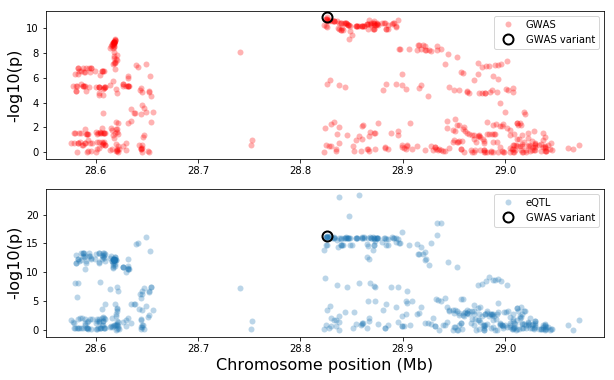

In [37]:
plot_attr = {'ms':12, 'alpha':0.3, 'mec':'none'}  # define plot styles

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(211)
ax.plot(gwas_subset_df.loc[shared_ix, 'position']/1e6, -np.log10(gwas_subset_df.loc[shared_ix, 'P']), 'r.', label='GWAS', **plot_attr)
ax.plot(gwas_variant_pos/1e6, -np.log10(gwas_subset_df.loc[chrom+'_'+str(gwas_variant_pos), 'P']), 'ko', mfc='none', ms=10, mew=2, label='GWAS variant')
ax.set_ylabel('-log10(p)', fontsize=16)
ax.legend()
ax = fig.add_subplot(212)
ax.plot(eqtl_subset_df.loc[shared_ix, 'variant_pos']/1e6, -np.log10(eqtl_subset_df.loc[shared_ix, 'pval_nominal']), '.', label='eQTL', **plot_attr)
ax.plot(gwas_variant_pos/1e6, -np.log10(eqtl_subset_df.loc[chrom+'_'+str(gwas_variant_pos), 'pval_nominal']), 'ko', mfc='none', ms=10, mew=2, label='GWAS variant')

ax.set_xlabel('Chromosome position (Mb)', fontsize=16)
ax.set_ylabel('-log10(p)', fontsize=16)
ax.legend();

In this visualization, the GWAS and eQTL peaks appear to co-occur. To confirm this, we calculate the correlation between the GWAS and eQTL p-values. 

Spearman correlation: 0.827131
  * p-value: 1.71353e-135


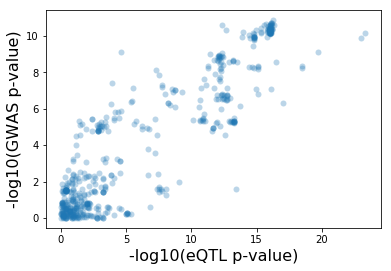

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(-np.log10(eqtl_subset_df.loc[shared_ix, 'pval_nominal']), -np.log10(gwas_subset_df.loc[shared_ix, 'P']), '.', **plot_attr)
ax.set_xlabel('-log10(eQTL p-value)', fontsize=16)
ax.set_ylabel('-log10(GWAS p-value)', fontsize=16)

r,p = stats.spearmanr(eqtl_subset_df.loc[shared_ix, 'pval_nominal'], gwas_subset_df.loc[shared_ix, 'P'])
print('Spearman correlation: {:.6g}'.format(r))
print('  * p-value: {:.6g}'.format(p))

To establish whether a causal relationship between the tested eQTL and GWAS variant exists, a more sophisticated colocalization analysis of the GWAS and eQTL summary statistics is needed ([Nica et al., PLoS Genetics 2010](http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1000895); [He et al., AJHG 2013](http://www.sciencedirect.com/science/article/pii/S0002929713001596); [Giambartolome et al., PLoS Genetics 2014](http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1004383); [Hormozdiari et al. AJHG 2016](http://www.sciencedirect.com/science/article/pii/S0002929716304396)). Additionally, the GWAS p-values should be compared against the eQTL p-values of other genes in the region, and other tissues can be tested.

### User Survey

Please take a few minutes to respond to our [survey](https://www.surveymonkey.com/r/J3VDNKC) about GTEx data usage and user needs.